# Latent Diffusion: Training & Inference on CelebA-HQ

This notebook implements the training of a Latent Diffusion Model (LDM) on the CelebA-HQ dataset, followed by Sequential Monte Carlo (SMC) inference for emotion editing.

### Prerequisites
The dataset must be added to the Kaggle environment (e.g., `badasstechie/celebahq-resized-256x256`).
The expected path is `/kaggle/input/celebahq-resized-256x256`.

You should also add your unet trained model to the Kaggle environment.
If you want to track training progress using WandB, you can add your WANDB_API_KEY to Kaggle Secrets.

## 1. Environment and Configuration Setup

###  Dependencies

In [42]:
!pip install -q diffusers accelerate transformers wandb

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import glob
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
from diffusers import AutoencoderKL, UNet2DModel, DDPMScheduler
from accelerate import Accelerator
import wandb
from transformers import AutoImageProcessor, AutoModelForImageClassification
from dotenv import load_dotenv

print("Libraries installed and imported.")

Libraries installed and imported.


### Global Configuration & Hyperparameters

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"

TRAIN_CONFIG = {
    "data_dir": "/kaggle/input/celebahq-resized-256x256",
    "output_dir": "checkpoints",
    "batch_size": 32,
    "epochs": 100, 
    "lr": 1e-4,
    "mixed_precision": "fp16",
    "gradient_accumulation_steps": 1,
    "num_train_timesteps": 1000,
    "beta_schedule": "scaled_linear",
    "prediction_type": "epsilon",
    "checkpoint_path": None,  # For continuing training from a checkpoint
    "start_epoch": 0  # You may specify the starting epoch if resuming
}

TEST_ONLY = True # For skipping the training loop

TEST_CONFIG = {
    "data_dir": "/kaggle/input/celebahq-resized-256x256", 
    "output_dir": "/results",
    "trained_unet_path": "checkpoint-epoch-89",
    "test_image_path": "testimage.jpg"
}

print(f"Device used: {DEVICE}")
print("Configuration loaded.")

Device used: mps
Configuration loaded.


###  Experiment Tracking with Weights & Biases

In [ ]:
# Automatic connection to WandB via Kaggle Secrets
load_dotenv() 

if "WANDB_API_KEY" in os.environ:
    wandb.login(key=os.environ["WANDB_API_KEY"])
    print("Connected to WandB via Environment Variable.")
else:
    try:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        wandb_key = user_secrets.get_secret("WANDB_API_KEY")
        wandb.login(key=wandb_key)
        print("Connected to WandB via Kaggle Secrets.")
    except Exception as e:
        print(f"Unable to automatically connect to WandB: {e}")
        print("Please ensure 'WANDB_API_KEY' is added in Add-ons -> Secrets.")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.


here


ValueError: API key must be 40 characters long, yours was 23

## 2. Loading datasets and models

### Dataset Loading & Preprocessing

In [ ]:
class CelebAHQDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        # Recursive search for images
        self.image_paths = glob.glob(os.path.join(root_dir, "**", "*.jpg"), recursive=True) + \
                           glob.glob(os.path.join(root_dir, "**", "*.png"), recursive=True)
        
        print(f"Found {len(self.image_paths)} images in {root_dir}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return self.__getitem__((idx + 1) % len(self))
            
        if self.transform:
            image = self.transform(image)
            
        return image

def get_transforms(image_size=256):
    return transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        # Normalize RGB (3 channels) to [-1, 1]
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) 
    ])

### Model Loading: VAE, UNet & Emotion Classifier

In [ ]:
def get_vae(model_id="runwayml/stable-diffusion-v1-5"):
    print(f"Loading VAE from {model_id}...")
    vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae")
    vae.eval()
    vae.requires_grad_(False) # Freeze VAE
    return vae

def get_unet(image_size=32, in_channels=4, out_channels=4):
    # image_size here is the latent size (256 / 8 = 32)
    print(f"Creating UNet2DModel with input/output channels={in_channels}, latent_size={image_size}...")
    unet = UNet2DModel(
        sample_size=image_size,
        in_channels=in_channels,
        out_channels=out_channels,
        layers_per_block=2,
        block_out_channels=(128, 128, 256, 256, 512, 512),
        down_block_types=(
            "DownBlock2D", "DownBlock2D", "DownBlock2D", "DownBlock2D", "AttnDownBlock2D", "DownBlock2D",
        ),
        up_block_types=(
            "UpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D", "UpBlock2D", "UpBlock2D",
        ),
    )
    
    # Calculate and display number of parameters
    num_params = sum(p.numel() for p in unet.parameters() if p.requires_grad)
    print(f"--> UNet model initialized with {num_params:,} parameters.")
    
    return unet

def get_emotion_classifier(model_id="dima806/facial_emotions_image_detection"):
    print(f"Loading Emotion Classifier from {model_id}...")
    processor = AutoImageProcessor.from_pretrained(model_id)
    model = AutoModelForImageClassification.from_pretrained(model_id)
    model.eval()
    model.requires_grad_(False)
    return processor, model

## 3. Training Loop

In [ ]:
def simple_inference(unet, num_samples=4, save_path=None):
    device = DEVICE
    
    # If unet is wrapped by accelerator, use it directly or unwrap
    if isinstance(unet, torch.nn.parallel.DistributedDataParallel):
        unet = unet.module
    unet.to(device)
    unet.eval()
    
    vae = get_vae().to(device)
    
    # Scheduler for inference (Important : it must be the same config as train)
    scheduler = DDPMScheduler(
        num_train_timesteps=TRAIN_CONFIG["num_train_timesteps"],
        beta_schedule=TRAIN_CONFIG["beta_schedule"],
        prediction_type=TRAIN_CONFIG["prediction_type"],
        clip_sample=False
    )
    scheduler.set_timesteps(TRAIN_CONFIG["num_train_timesteps"])
    
    # 1. Generate initial noise (Latents)
    latents = torch.randn((num_samples, 4, 32, 32), device=device)
    
    # Indices to capture progress (0%, 25%, 50%, 75%, 100%)
    total_steps = TRAIN_CONFIG["num_train_timesteps"]
    capture_indices = [0, total_steps // 4, total_steps // 2, 3 * total_steps // 4] 
    captured_images = []
    
    print("Starting inference...")
    for i, t in enumerate(tqdm(scheduler.timesteps)):
        # Intermediate capture
        if i in capture_indices:
            with torch.no_grad():
                # Quick decode for visualization
                temp_latents = latents / vae.config.scaling_factor
                decoded = vae.decode(temp_latents).sample
                decoded = (decoded / 2 + 0.5).clamp(0, 1)
                decoded = decoded.cpu().permute(0, 2, 3, 1).numpy()
                captured_images.append(decoded)

        with torch.no_grad():
            # Predict noise
            noise_pred = unet(latents, t).sample
            
            # Scheduler step (remove noise)
            latents = scheduler.step(noise_pred, t, latents).prev_sample
            
    # Final capture (100%)
    with torch.no_grad():
        latents = latents / vae.config.scaling_factor
        images = vae.decode(latents).sample
        images = (images / 2 + 0.5).clamp(0, 1)
        images = images.cpu().permute(0, 2, 3, 1).numpy()
        captured_images.append(images)
        
    # 3. Display: Grid (num_samples x 5)
    num_steps = len(captured_images)
    fig, axes = plt.subplots(num_samples, num_steps, figsize=(3 * num_steps, 3 * num_samples))
    
    # Handle case num_samples=1
    if num_samples == 1:
        axes = axes.reshape(1, -1)
        
    for i in range(num_samples):
        for j in range(num_steps):
            axes[i, j].imshow(captured_images[j][i])
            axes[i, j].axis("off")
            if i == 0:
                step_label = f"Step {capture_indices[j]}" if j < len(capture_indices) else "Final"
                axes[i, j].set_title(step_label)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
        print(f"Saved visualization to {save_path}")
        plt.close(fig)
    else:
        plt.show()
        
# Training Loop        
def train_loop():
    # Use global configuration
    config = TRAIN_CONFIG.copy()
    
    # Check dataset path (fallback if local for test)
    if not os.path.exists(config["data_dir"]):
        print(f"Warning: {config['data_dir']} not found. Checking local ./data...")
        if os.path.exists("./data"):
            config["data_dir"] = "./data"
        else:
            print("Error: Dataset not found.")
            return

    # Initialize Accelerator with WandB
    accelerator = Accelerator(
        mixed_precision=config["mixed_precision"],
        gradient_accumulation_steps=config["gradient_accumulation_steps"],
        log_with="wandb"
    )

    if accelerator.is_main_process:
        os.makedirs(config["output_dir"], exist_ok=True)
        # Initialize WandB project
        accelerator.init_trackers("celebahq-latent-diffusion", config=config)

    # Load Models
    vae = get_vae()
    
    resume_from_checkpoint = config["checkpoint_path"] 
    start_epoch = config["start_epoch"] if resume_from_checkpoint else 0
    if resume_from_checkpoint:
        print(f"Resuming training from: {resume_from_checkpoint}")
        # Load pre-trained UNet
        unet = UNet2DModel.from_pretrained(resume_from_checkpoint)
    else:
        unet = get_unet(image_size=32)
    
    # Scheduler Configuration 
    noise_scheduler = DDPMScheduler(
        num_train_timesteps=config["num_train_timesteps"],
        beta_schedule=config["beta_schedule"],
        prediction_type=config["prediction_type"],
        clip_sample=False # Important for latent diffusion
    )

    # Freeze VAE and move to device
    vae.to(accelerator.device)
    vae.eval()

    # Optimizer
    optimizer = torch.optim.AdamW(unet.parameters(), lr=config["lr"])

    # Dataset & Dataloader
    dataset = CelebAHQDataset(root_dir=config["data_dir"], transform=get_transforms(256))
    
    # IMPORTANT: num_workers=0 to avoid blocks on macOS or some notebooks
    train_dataloader = DataLoader(
        dataset, batch_size=config["batch_size"], shuffle=True, num_workers=0, pin_memory=True
    )

    # Prepare
    unet, optimizer, train_dataloader = accelerator.prepare(
        unet, optimizer, train_dataloader
    )

    # Training Loop
    global_step = 0
    
    print(f"Starting training from epoch {start_epoch} to {start_epoch + config['epochs'] - 1}")
    
    for epoch in range(start_epoch, start_epoch + config["epochs"]):
        unet.train()
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch # Accelerator handles device
            
            # Encode images to latents
            with torch.no_grad():
                latents = vae.encode(clean_images).latent_dist.sample()
                latents = latents * vae.config.scaling_factor

            # Sample noise
            noise = torch.randn_like(latents)
            bs = latents.shape[0]
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bs,), device=latents.device).long()

            # Add noise
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            # Predict noise
            with accelerator.accumulate(unet):
                noise_pred = unet(noisy_latents, timesteps).sample
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)
                optimizer.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            progress_bar.set_postfix(loss=loss.item())
            global_step += 1
            
            # Log loss to WandB
            accelerator.log({"train_loss": loss.item()}, step=global_step)

        # Save Checkpoint & Inference
        if accelerator.is_main_process:
            # Save every 5 epochs OR at the last epoch
            if (epoch + 1) % 5 == 0 or epoch == start_epoch + config["epochs"] - 1:
                # Use unwrap_model to save cleanly
                unwrapped_unet = accelerator.unwrap_model(unet)
                save_path = os.path.join(config["output_dir"], f"checkpoint-epoch-{epoch}")
                unwrapped_unet.save_pretrained(save_path)
                print(f"Saved model to {save_path}")
                
            
            # Inference visualization (every epoch for tracking)
            # Use unwrap_model here too for inference
            unwrapped_unet = accelerator.unwrap_model(unet)
            print(f"Running inference visualization for epoch {epoch}...")
            vis_path = os.path.join(config["output_dir"], f"vis_epoch_{epoch}.png")
            simple_inference(unwrapped_unet, num_samples=4, save_path=vis_path)
            
            # Log image to WandB
            accelerator.log({"inference_samples": wandb.Image(vis_path)}, step=global_step)

    accelerator.end_training()
    print("Training finished.")
    return unet # Returns trained model (wrapped)

In [ ]:
if not TEST_ONLY:
    trained_unet = train_loop()

Checkpoint non trouvé à checkpoint-epoch-44. Lancement d'un nouvel entraînement...
Error: Dataset not found.


## 4. Sequential Monte Carlo (SMC) Inference

### Simple SMC inference test

Loading VAE from runwayml/stable-diffusion-v1-5...
Loading Emotion Classifier from dima806/facial_emotions_image_detection...
Loading Emotion Classifier from dima806/facial_emotions_image_detection...
Target: sad (ID: 0)
Loading image from testimage.jpg...
Target: sad (ID: 0)
Loading image from testimage.jpg...
Starting SMC Inference with 10 particles, target='sad'...
Starting SMC Inference with 10 particles, target='sad'...


  0%|          | 0/51 [00:00<?, ?it/s]

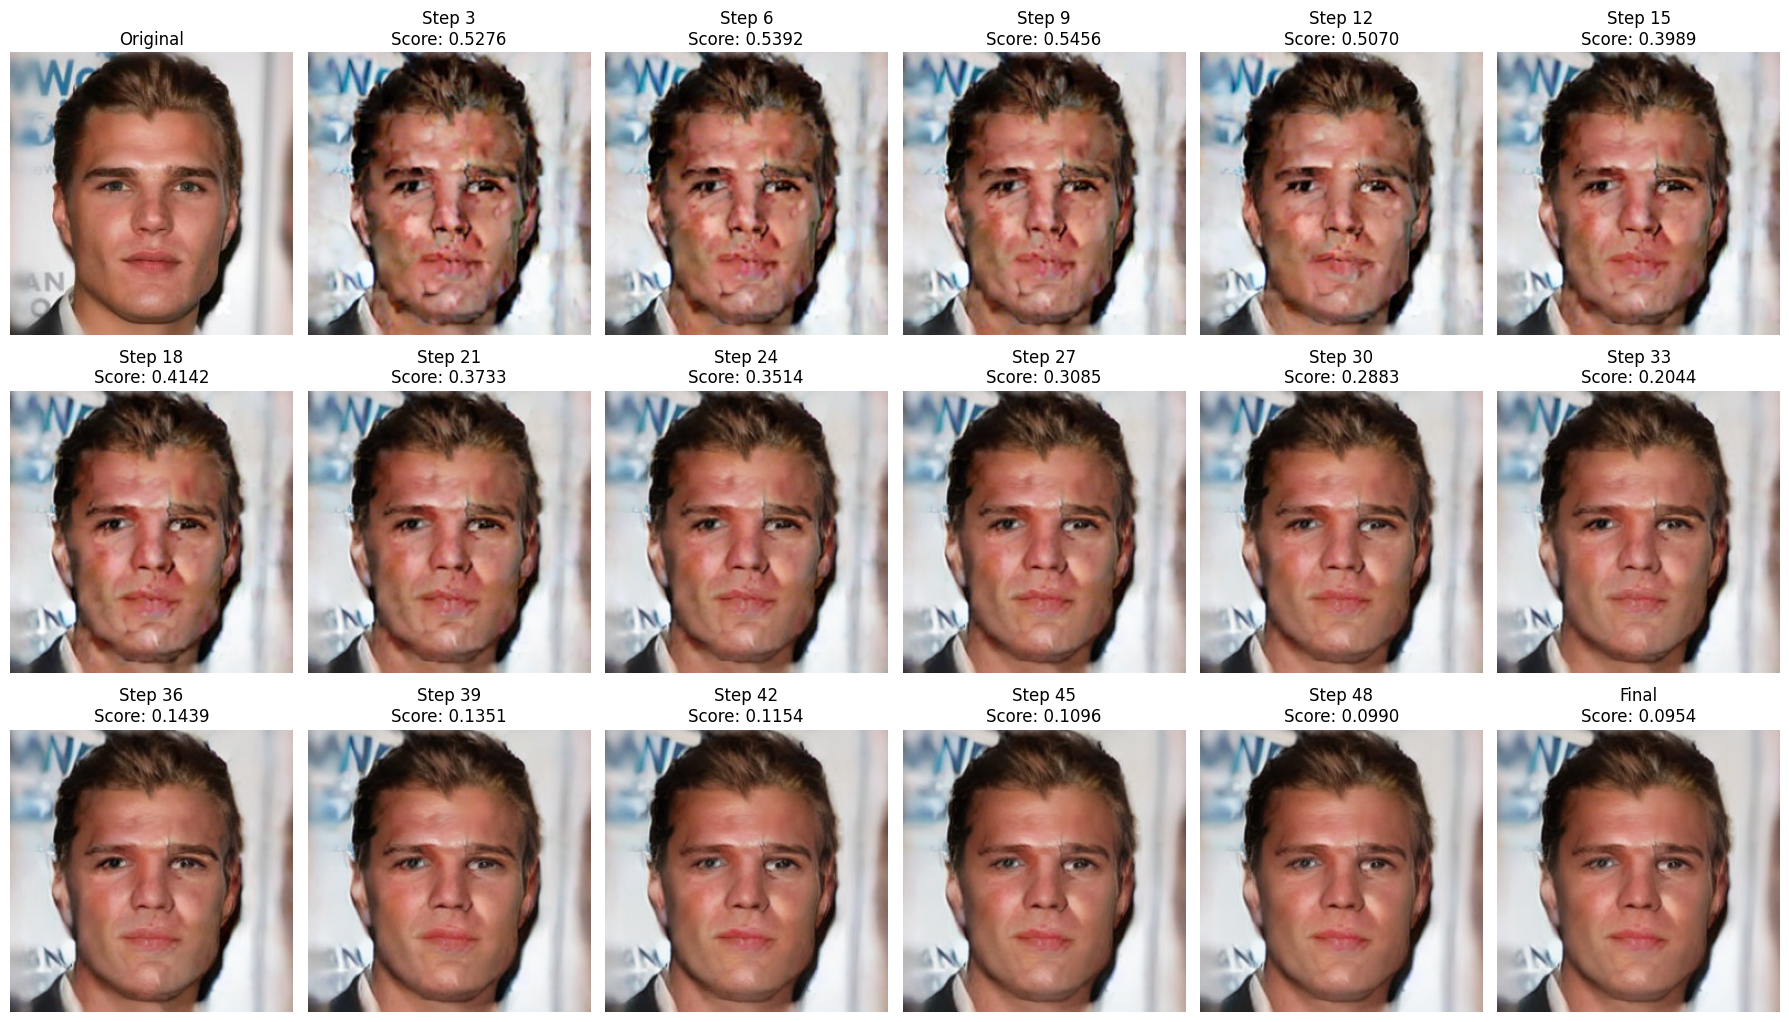

In [ ]:
def smc_image_inference(image_path, target_emotion, num_particles=10, steps=50, guidance_scale=2.0, noise_strength=0.3, resample_interval=1, leash=0.0):
    """
    Applies SMC inference to modify the emotion of an existing image.
    Displays the progression of the best sample at each resampling step.
    """
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return

    device = DEVICE
    
    # 1. Load Models
    unet = UNet2DModel.from_pretrained(TEST_CONFIG["trained_unet_path"])
    unet.to(device)
    unet.eval()
    
    vae = get_vae().to(device)
    processor, classifier = get_emotion_classifier()
    classifier.to(device)
    
    # Check emotion
    id2label = classifier.config.id2label
    label2id = {v.lower(): k for k, v in id2label.items()}
    if target_emotion.lower() not in label2id:
        print(f"Emotion '{target_emotion}' not found. Available: {list(label2id.keys())}")
        return
    target_class_id = label2id[target_emotion.lower()]
    print(f"Target: {target_emotion} (ID: {target_class_id})")

    # 2. Load & Preprocess Image
    print(f"Loading image from {image_path}...")
    transform = get_transforms(256)
    original_pil = Image.open(image_path).convert("RGB")
    image_tensor = transform(original_pil).unsqueeze(0).to(device)
    
    # 3. Encode to Latents
    with torch.no_grad():
        latents = vae.encode(image_tensor).latent_dist.sample()
        latents = latents * vae.config.scaling_factor
        
    # Duplicate latents for particles
    latents = latents.repeat(num_particles, 1, 1, 1)
    
    # 4. Setup Scheduler
    scheduler = DDPMScheduler(
        num_train_timesteps=TRAIN_CONFIG["num_train_timesteps"],
        beta_schedule=TRAIN_CONFIG["beta_schedule"],
        prediction_type=TRAIN_CONFIG["prediction_type"],
        clip_sample=False
    )
    scheduler.set_timesteps(steps)
    timesteps = scheduler.timesteps
    
    # 5. Add Noise (Start from t_start)
    noise = torch.randn_like(latents)
    start_idx = int((1.0 - noise_strength) * (len(timesteps) - 1))
    t_start = timesteps[start_idx]
    curr_latents = scheduler.add_noise(latents, noise, t_start)
    
    print(f"Starting SMC Inference with {num_particles} particles, target='{target_emotion}'...")
    
    # Prepare normalization constants from processor
    # Default to ImageNet stats if not found
    image_mean = getattr(processor, "image_mean", [0.485, 0.456, 0.406])
    image_std = getattr(processor, "image_std", [0.229, 0.224, 0.225])
    
    norm_mean = torch.tensor(image_mean, device=device).view(1, 3, 1, 1)
    norm_std = torch.tensor(image_std, device=device).view(1, 3, 1, 1)

    progression_images = []

    # 6. SMC Loop
    for i, t in enumerate(tqdm(timesteps[start_idx:])):
        # A. Denoise Step
        with torch.no_grad():
            noise_pred = unet(curr_latents, t).sample
            curr_latents = scheduler.step(noise_pred, t, curr_latents).prev_sample
            
            leash_t = leash * (1-i)/t_start
            curr_latents = (1 - leash_t) * curr_latents + leash_t * latents
            
        # B. Resampling Step
        # Do not resample at the very last step
        if (i + 1) % resample_interval == 0 and (i + 1) < len(timesteps[start_idx:]):
            with torch.no_grad():
                # Decode for classification
                temp_latents = curr_latents / vae.config.scaling_factor
                decoded = vae.decode(temp_latents).sample
                decoded = (decoded / 2 + 0.5).clamp(0, 1)
                
                # Resize for classifier (224x224)
                images_resized = F.interpolate(decoded, size=(224, 224), mode='bilinear', align_corners=False)
                
                # Normalize for classifier using processor stats
                classifier_inputs = (images_resized - norm_mean) / norm_std
                
                # Classify
                outputs = classifier(pixel_values=classifier_inputs)
                probs = F.softmax(outputs.logits, dim=-1)
                
                # Weighting
                target_probs = probs[:, target_class_id]
                
                # --- Capture Best Particle ---
                best_idx = torch.argmax(target_probs)
                best_score = target_probs[best_idx].item()
                best_img = decoded[best_idx].cpu().permute(1, 2, 0).numpy()
                progression_images.append((f"Step {i+1}", best_img, best_score))
                # -----------------------------

                weights = target_probs ** guidance_scale
                
                if weights.sum() == 0:
                    weights = torch.ones_like(weights) / len(weights)
                else:
                    weights = weights / weights.sum()
                    
                # Resample indices
                indices = torch.multinomial(weights, num_samples=num_particles, replacement=True)
                curr_latents = curr_latents[indices]
                
    # 7. Final Decode & Scoring
    with torch.no_grad():
        curr_latents = curr_latents / vae.config.scaling_factor
        result_images_tensor = vae.decode(curr_latents).sample
        result_images_tensor = (result_images_tensor / 2 + 0.5).clamp(0, 1)
        
        # Compute scores for final particles
        images_resized = F.interpolate(result_images_tensor, size=(224, 224), mode='bilinear', align_corners=False)
        classifier_inputs = (images_resized - norm_mean) / norm_std
        
        outputs = classifier(pixel_values=classifier_inputs)
        probs = F.softmax(outputs.logits, dim=-1)
        final_scores = probs[:, target_class_id].cpu().numpy()
        
        # Convert to numpy for display
        result_images = result_images_tensor.cpu().permute(0, 2, 3, 1).numpy()
        
        # Add final best
        best_final_idx = np.argmax(final_scores)
        progression_images.append(("Final", result_images[best_final_idx], final_scores[best_final_idx]))
        
    # 8. Show Progression
    num_images = len(progression_images) + 1
    # Adjust figure size based on number of images
    cols = min(num_images, 6)
    rows = (num_images + cols - 1) // cols
    
    plt.figure(figsize=(3 * cols, 3.5 * rows))
    
    # Original
    plt.subplot(rows, cols, 1)
    plt.title("Original")
    plt.imshow(original_pil)
    plt.axis("off")
    
    for k, (label, img, score) in enumerate(progression_images):
        plt.subplot(rows, cols, k + 2)
        plt.title(f"{label}\nScore: {score:.4f}")
        plt.imshow(img)
        plt.axis("off")
        
    plt.tight_layout()
    plt.show()

In [ ]:
test_image_path = TEST_CONFIG["test_image_path"]
smc_image_inference(test_image_path, target_emotion="sad", num_particles=20, steps=250, guidance_scale=5.0, noise_strength=0.23, resample_interval=1)

### Dual SMC inference test

In [ ]:
def smc_image_inference_dual(image_path, target_emotion1, target_emotion2, num_particles=10, steps=50, guidance_scale=2.0, noise_strength=0.3,  resample_interval=1, leash=0.0):
    """
    Applies SMC inference for two target emotions and displays the original and both final results.
    """
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return

    device = DEVICE
    
    # 1. Load Models
    unet = UNet2DModel.from_pretrained(TEST_CONFIG["trained_unet_path"])
    unet.to(device)
    unet.eval()
    
    vae = get_vae().to(device)
    processor, classifier = get_emotion_classifier()
    classifier.to(device)
    
    # Check emotions
    id2label = classifier.config.id2label
    label2id = {v.lower(): k for k, v in id2label.items()}
    
    targets = []
    for emo in [target_emotion1, target_emotion2]:
        if emo.lower() not in label2id:
            print(f"Emotion '{emo}' not found. Available: {list(label2id.keys())}")
            return
        targets.append((emo, label2id[emo.lower()]))

    # 2. Load & Preprocess Image (Common)
    print(f"Loading image from {image_path}...")
    transform = get_transforms(256)
    original_pil = Image.open(image_path).convert("RGB")
    image_tensor = transform(original_pil).unsqueeze(0).to(device)
    
    # Normalization constants
    image_mean = getattr(processor, "image_mean", [0.485, 0.456, 0.406])
    image_std = getattr(processor, "image_std", [0.229, 0.224, 0.225])
    norm_mean = torch.tensor(image_mean, device=device).view(1, 3, 1, 1)
    norm_std = torch.tensor(image_std, device=device).view(1, 3, 1, 1)

    results = []

    for target_emotion, target_class_id in targets:
        print(f"Starting SMC Inference for target='{target_emotion}'...")
        
        with torch.no_grad():
            latents = vae.encode(image_tensor).latent_dist.sample()
            latents = latents * vae.config.scaling_factor
            
        # Duplicate latents for particles
        latents = latents.repeat(num_particles, 1, 1, 1)
        
        # 4. Setup Scheduler
        scheduler = DDPMScheduler(
            num_train_timesteps=TRAIN_CONFIG["num_train_timesteps"],
            beta_schedule=TRAIN_CONFIG["beta_schedule"],
            prediction_type=TRAIN_CONFIG["prediction_type"],
            clip_sample=False
        )
        scheduler.set_timesteps(steps)
        timesteps = scheduler.timesteps
        
        # 5. Add Noise
        noise = torch.randn_like(latents)
        start_idx = int((1.0 - noise_strength) * (len(timesteps) - 1))
        t_start = timesteps[start_idx]
        curr_latents = scheduler.add_noise(latents, noise, t_start)
        
        # 6. SMC Loop
        for i, t in enumerate(tqdm(timesteps[start_idx:], desc=f"SMC {target_emotion}")):
            # A. Denoise Step
            with torch.no_grad():
                noise_pred = unet(curr_latents, t).sample
                curr_latents = scheduler.step(noise_pred, t, curr_latents).prev_sample
                
                leash_t = leash * (1-i)/t_start
                curr_latents = (1 - leash_t) * curr_latents + leash_t * latents
                
            # B. Resampling Step
            if (i + 1) % resample_interval == 0 and (i + 1) < len(timesteps[start_idx:]):
                with torch.no_grad():
                    temp_latents = curr_latents / vae.config.scaling_factor
                    decoded = vae.decode(temp_latents).sample
                    decoded = (decoded / 2 + 0.5).clamp(0, 1)
                    images_resized = F.interpolate(decoded, size=(224, 224), mode='bilinear', align_corners=False)
                    classifier_inputs = (images_resized - norm_mean) / norm_std
                    outputs = classifier(pixel_values=classifier_inputs)
                    probs = F.softmax(outputs.logits, dim=-1)
                    target_probs = probs[:, target_class_id]
                    
                    weights = target_probs ** guidance_scale
                    if weights.sum() == 0:
                        weights = torch.ones_like(weights) / len(weights)
                    else:
                        weights = weights / weights.sum()
                        
                    indices = torch.multinomial(weights, num_samples=num_particles, replacement=True)
                    curr_latents = curr_latents[indices]
        
        # 7. Final Decode & Scoring
        with torch.no_grad():
            curr_latents = curr_latents / vae.config.scaling_factor
            result_images_tensor = vae.decode(curr_latents).sample
            result_images_tensor = (result_images_tensor / 2 + 0.5).clamp(0, 1)
            
            images_resized = F.interpolate(result_images_tensor, size=(224, 224), mode='bilinear', align_corners=False)
            classifier_inputs = (images_resized - norm_mean) / norm_std
            
            outputs = classifier(pixel_values=classifier_inputs)
            probs = F.softmax(outputs.logits, dim=-1)
            final_scores = probs[:, target_class_id].cpu().numpy()
            
            result_images = result_images_tensor.cpu().permute(0, 2, 3, 1).numpy()
            
            best_final_idx = np.argmax(final_scores)
            results.append((target_emotion, result_images[best_final_idx], final_scores[best_final_idx]))

    # 8. Save and Provide Link
    plt.figure(figsize=(15, 5))
    
    # Original
    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(original_pil)
    plt.axis("off")
    
    # Result 1
    plt.subplot(1, 3, 2)
    plt.title(f"{results[0][0]}\nScore: {results[0][2]:.4f}")
    plt.imshow(results[0][1])
    plt.axis("off")
    
    # Result 2
    plt.subplot(1, 3, 3)
    plt.title(f"{results[1][0]}\nScore: {results[1][2]:.4f}")
    plt.imshow(results[1][1])
    plt.axis("off")
    
    plt.tight_layout()
    
    output_filename = "dual_inference_result.png"
    plt.savefig(output_filename)
    plt.show()
    
    print(f"Image saved to: {output_filename}")
    from IPython.display import FileLink, display
    display(FileLink(output_filename))

In [ ]:
test_image_path = TEST_CONFIG["test_image_path"]
smc_image_inference_dual(test_image_path, 'happy', 'sad', num_particles=20, steps=250, guidance_scale=2.0, noise_strength=0.23, resample_interval=1)

Loading VAE from runwayml/stable-diffusion-v1-5...


NameError: name 'get_emotion_classifier' is not defined

## 5. Benchmarking & Metrics Analysis

In [ ]:
!pip install -q facenet-pytorch
import torch
import numpy as np
import pandas as pd
from facenet_pytorch import MTCNN
import random

def smc_inference_core(image_path, unet, vae, classifier, processor, target_emotion, num_particles, steps, guidance_scale, noise_strength, leash, resample_interval):
    device = unet.device
    
    # Check emotion
    id2label = classifier.config.id2label
    label2id = {v.lower(): k for k, v in id2label.items()}
    if target_emotion.lower() not in label2id:
        return None, 0.0
    target_class_id = label2id[target_emotion.lower()]

    # Load & Preprocess
    transform = get_transforms(256)
    original_pil = Image.open(image_path).convert("RGB")
    image_tensor = transform(original_pil).unsqueeze(0).to(device)
    
    # Encode
    with torch.no_grad():
        latents = vae.encode(image_tensor).latent_dist.sample()
        latents = latents * vae.config.scaling_factor
        
    latents = latents.repeat(num_particles, 1, 1, 1)
    
    # Scheduler
    scheduler = DDPMScheduler(
        num_train_timesteps=TRAIN_CONFIG["num_train_timesteps"],
        beta_schedule=TRAIN_CONFIG["beta_schedule"],
        prediction_type=TRAIN_CONFIG["prediction_type"],
        clip_sample=False
    )
    scheduler.set_timesteps(steps)
    timesteps = scheduler.timesteps
    
    # Add Noise
    noise = torch.randn_like(latents)
    start_idx = int((1.0 - noise_strength) * (len(timesteps) - 1))
    t_start = timesteps[start_idx]
    curr_latents = scheduler.add_noise(latents, noise, t_start)
    
    # Normalization constants
    image_mean = getattr(processor, "image_mean", [0.485, 0.456, 0.406])
    image_std = getattr(processor, "image_std", [0.229, 0.224, 0.225])
    norm_mean = torch.tensor(image_mean, device=device).view(1, 3, 1, 1)
    norm_std = torch.tensor(image_std, device=device).view(1, 3, 1, 1)

    # SMC Loop
    for i, t in enumerate(timesteps[start_idx:]):
        # Denoise
        with torch.no_grad():
            noise_pred = unet(curr_latents, t).sample
            curr_latents = scheduler.step(noise_pred, t, curr_latents).prev_sample
            
            leash_t = leash * (1-i)/t_start
            curr_latents = (1 - leash_t) * curr_latents + leash_t * latents
            
        # Resample
        if (i + 1) % resample_interval == 0 and (i + 1) < len(timesteps[start_idx:]):
            with torch.no_grad():
                temp_latents = curr_latents / vae.config.scaling_factor
                decoded = vae.decode(temp_latents).sample
                decoded = (decoded / 2 + 0.5).clamp(0, 1)
                images_resized = F.interpolate(decoded, size=(224, 224), mode='bilinear', align_corners=False)
                classifier_inputs = (images_resized - norm_mean) / norm_std
                outputs = classifier(pixel_values=classifier_inputs)
                probs = F.softmax(outputs.logits, dim=-1)
                target_probs = probs[:, target_class_id]
                
                weights = target_probs ** guidance_scale
                if weights.sum() == 0:
                    weights = torch.ones_like(weights) / len(weights)
                else:
                    weights = weights / weights.sum()
                    
                indices = torch.multinomial(weights, num_samples=num_particles, replacement=True)
                curr_latents = curr_latents[indices]
                
    # Final Decode
    with torch.no_grad():
        curr_latents = curr_latents / vae.config.scaling_factor
        result_images_tensor = vae.decode(curr_latents).sample
        result_images_tensor = (result_images_tensor / 2 + 0.5).clamp(0, 1)
        
        images_resized = F.interpolate(result_images_tensor, size=(224, 224), mode='bilinear', align_corners=False)
        classifier_inputs = (images_resized - norm_mean) / norm_std
        outputs = classifier(pixel_values=classifier_inputs)
        probs = F.softmax(outputs.logits, dim=-1)
        final_scores = probs[:, target_class_id].cpu().numpy()
        
        best_idx = np.argmax(final_scores)
        best_score = final_scores[best_idx]
        best_image_tensor = result_images_tensor[best_idx] # [3, H, W]
        
    return best_image_tensor, best_score

def run_benchmark_tests(tests, images_per_test=10):
    print("Initializing benchmark...")
    
    # 1. Setup Data
    base_dir = TRAIN_CONFIG["data_dir"]
    if not os.path.exists(base_dir):
        print(f"⚠️ Path {base_dir} not found. Check dataset.")
        image_paths = []
    else:
        # Select first N images
        all_files = sorted(os.listdir(base_dir))
        image_paths = []
        for filename in all_files:
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(base_dir, filename))
            if len(image_paths) >= images_per_test:
                break

    # 2. Setup Models
    device = DEVICE
    resume_from_checkpoint = TRAIN_CONFIG["checkpoint_path"]
    
    print("Loading models...")
    if resume_from_checkpoint and os.path.exists(resume_from_checkpoint):
        unet = UNet2DModel.from_pretrained(resume_from_checkpoint)
    else:
        print(f"Checkpoint {resume_from_checkpoint} not found.")
        return()
    
    unet.to(device)
    unet.eval()
    
    vae = get_vae().to(device)
    processor, classifier = get_emotion_classifier()
    classifier.to(device)
    
    # Initialize MTCNN
    print("Initializing MTCNN...")
    mtcnn = MTCNN(keep_all=True, device=device)
    
    
    results_log = []

    for test in tests:
        print(f"\n=== Running {test['name']} ===")
        for val in test['values']:
            params = test['fixed'].copy()
            params[test['var']] = val
            
            print(f"Testing {test['var']} = {val} ...")
            
            scores = []
            face_probs = []
            
            for img_path in tqdm(image_paths, leave=False):
                # Run Inference
                target_emotion = random.choice(["happy", "sad", "angry", "surprise", "neutral", "fear", "disgust"])
                final_img_tensor, score = smc_inference_core(
                    img_path, unet, vae, classifier, processor, target_emotion, 
                    num_particles=params.get("particles"),
                    steps=params.get("steps"),
                    guidance_scale=params.get("guidance_scale"),
                    noise_strength=params.get("noise_strength"),
                    leash=0.0,
                    resample_interval=1
                )
                
                scores.append(score)
                
                # MTCNN Detection
                try:
                    # Convert tensor [3, H, W] to PIL
                    img_np = final_img_tensor.cpu().permute(1, 2, 0).numpy()
                    img_pil = Image.fromarray((img_np * 255).astype(np.uint8))
                    
                    _, probs = mtcnn.detect(img_pil)
                    
                    if probs is not None and len(probs) > 0:
                        # Take max probability (but there should be one element in probs, since there is only one face)
                        face_probs.append(np.max(probs))
                    else:
                        face_probs.append(0.0)
                except Exception as e:
                    print(f"MTCNN Error: {e}")
                    face_probs.append(0.0)
                    
                # print("score:", score, "face_prob:", face_probs[-1])
                
            avg_score = np.mean(scores) if scores else 0.0
            avg_face_prob = np.mean(face_probs) if face_probs else 0.0
            
            print(f"-> Result: Avg Emotion Score={avg_score:.4f}, Avg Face Prob={avg_face_prob:.4f}")
            
            entry = params.copy()
            entry["tested_var"] = test['var']
            entry["tested_value"] = val
            entry["Avg_Emotion_Score"] = avg_score
            entry["Avg_Face_Prob"] = avg_face_prob
            results_log.append(entry)
            
    # Display Final Table
    df_results = pd.DataFrame(results_log)
    print("\n=== Complete Results ===")
    display(df_results)
    return df_results

In [ ]:
tests = [
        {"name": "Guidance Scale Test", "fixed": {"particles": 20, "noise_strength": 0.2, "steps": 250}, "var": "guidance_scale", "values": [1, 2, 5, 10]},
        {"name": "Noise Strength Test", "fixed": {"particles": 20, "steps": 250, "guidance_scale": 5}, "var": "noise_strength", "values": [0.1, 0.2, 0.3, 0.7]},
        {"name": "Steps Test", "fixed": {"particles": 20, "noise_strength": 0.2, "guidance_scale": 5}, "var": "steps", "values": [50, 150, 250, 500]},
]

df_benchmark = run_benchmark_tests(tests, images_per_test=10)